## Objectives
In this notebook we take a first look at the new data and try to get some preliminary results with the models already developed.

## To do
* Create a function to take care of train test split and keras shaping 

## Importing libraries

In [18]:
import numpy as np
import time
import os

# keras
import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten,  AveragePooling2D, Conv2D
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator

# scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# data processing pipeline - see .py file
from data_processing import processing_pipeline
from data_processing import Scaler

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# for reloading
from importlib import reload

## Defining Model
In the future we should import from a models .py file

In [3]:
def get_pid_model(input_shape):
    model = Sequential()
    model.name = 'pid'

    model.add(Conv2D(32, (3, 3), input_shape=input_shape, name='L01', activation='relu'))
    model.add(Conv2D(32, (3, 3), name='L02', activation='relu'))

    model.add(AveragePooling2D(pool_size=(2, 2), name='L03'))
    model.add(Conv2D(64, (3, 3), name='L04', activation='relu'))
    model.add(Conv2D(64, (3, 3), name='L05', activation='relu'))

    model.add(AveragePooling2D(pool_size=(2, 2), name='L06'))

    model.add(Conv2D(128, (3, 3), name='L07', activation='relu'))
    model.add(Conv2D(128, (3, 3), name='L08', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), name='L09'))

    model.add(Flatten())
    model.add(Dense(256, name='L10', activation='relu'))
    model.add(Dense(256, name='L11', activation='relu'))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Importing and Processing Data
The file format is: `Subject_Measurement#_Person#_Painting ID`

In [7]:
data_folder = "C:/Users/Marcio/Downloads/Datasets/Research/Painter-ID/Large_12cmX15cm_50umResolution_400Hz/"

In [9]:
os.listdir(data_folder)

['WL_M1_P1_A_Height.txt',
 'WL_M1_P1_B_Height.txt',
 'WL_M1_P1_C_Height.txt',
 'WL_M1_P2_A_Height.txt',
 'WL_M1_P2_B_Height.txt',
 'WL_M1_P2_C_Height.txt']

In [93]:
train_test_samples = ['WL_M1_P1_A_Height.txt',
 'WL_M1_P1_B_Height.txt',
 'WL_M1_P2_A_Height.txt',
 'WL_M1_P2_B_Height.txt']

val_samples = ['WL_M1_P1_C_Height.txt',
 'WL_M1_P2_C_Height.txt']

painters = sorted(set([file.split('_')[2] for file in train_test_samples]))
paintings_train = sorted(set([file.split('_')[3] for file in train_test_samples]))
paintings_val = sorted(set([file.split('_')[3] for file in val_samples]))


data_id = ''.join(painters)+'_'+''.join(paintings_train)+'_'+''.join(paintings_val)
print("painters_traintest_val:\n", data_id)

painters_traintest_val:
 P1P2_AB_C


In [94]:
# getting X and y
files = [data_folder + sn for sn in train_test_samples]
y_list = [0,0,1,1]

patch_size = 64
X, y = processing_pipeline(files, patch_size, y_list)
print(f"There are {len(y)} patches.")

There are 6580 patches.


In [95]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y)
# reshaping for Keras
X_train = X_train.reshape(*X_train.shape,1)
X_test = X_test.reshape(*X_test.shape,1)
# getting y arrays for Keras
n_classes = len(set(y_list))
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

In [96]:
# Scaling
scaler = Scaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# saving scaler
timestamp = str(int(time.time()*1000000))[0:-1]
scaler_fname = f'./scalers/scaler_dataid{data_id}_patch_size_{patch_size}_tid{timestamp}.scaler'
scaler.save_scaler(scaler_fname)

## Training model

In [99]:
input_shape = X_train.shape[1:]
model = get_pid_model(input_shape)

In [100]:
# parameters for fit
batch_size = 32
epochs = 15

# fitting the model
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(X_test,y_test))

Train on 4935 samples, validate on 1645 samples
Epoch 1/15
4935/4935 [==============================] - 4s 788us/step - loss: 0.4661 - acc: 0.7700 - val_loss: 0.3628 - val_acc: 0.8614
Epoch 2/15
4935/4935 [==============================] - 3s 645us/step - loss: 0.2679 - acc: 0.8928 - val_loss: 0.1950 - val_acc: 0.9234
Epoch 3/15
4935/4935 [==============================] - 3s 650us/step - loss: 0.2063 - acc: 0.9187 - val_loss: 0.2365 - val_acc: 0.8930
Epoch 4/15
4935/4935 [==============================] - 3s 649us/step - loss: 0.1813 - acc: 0.9273 - val_loss: 0.2171 - val_acc: 0.9046
Epoch 5/15
4935/4935 [==============================] - 3s 650us/step - loss: 0.1655 - acc: 0.9329 - val_loss: 0.1720 - val_acc: 0.9356
Epoch 6/15
4935/4935 [==============================] - 3s 645us/step - loss: 0.1294 - acc: 0.9499 - val_loss: 0.1635 - val_acc: 0.9471
Epoch 7/15
4935/4935 [==============================] - 3s 651us/step - loss: 0.1312 - acc: 0.9508 - val_loss: 0.1757 - val_acc: 0.9356


### Saving model

In [193]:
timestamp = str(int(time.time()*1000000))[0:-1]
model.save(f'./models/{model.name}-did{data_id}-{timestamp}.h5')

## Looking at the validation set

In [180]:
from sklearn.metrics import accuracy_score

In [181]:
files_val = [data_folder + sn for sn in val_samples]
y_list_val = [0, 1]

X_val, y_val = processing_pipeline(files_val, patch_size, y_list_val)

In [182]:
# reshaping for Keras
X_val = X_val.reshape(*X_val.shape,1)

In [187]:
# Scaling
# load scaler here if necessary
X_val = scaler.transform(X_val)

In [190]:
y_val_predict = model.predict_classes(X_val)

In [191]:
accuracy_score(y_val, y_val_predict)

0.9133540372670808

### There is a problem. My guess is that there are too many outliers.

# Looking at the data

In [119]:
from data_processing import data_to_array

In [122]:
painting_arrays = [None]*len(files)
for i, f in enumerate(files):
    painting_arrays[i] = data_to_array(f)   

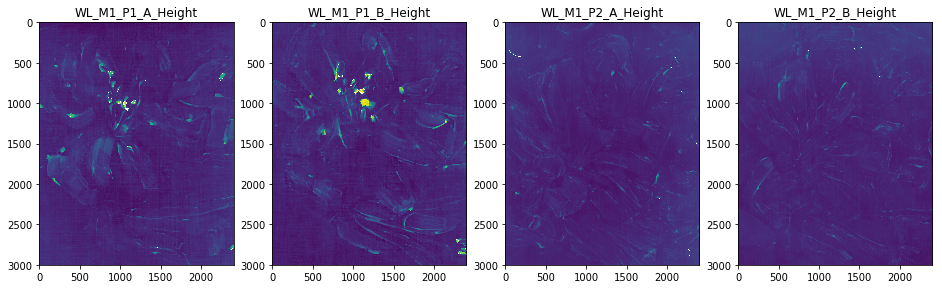

In [144]:
fig, axes = plt.subplots(1,len(painting_arrays), figsize=(4*len(painting_arrays),5))

for i in range(len(painting_arrays)):
    p = painting_arrays[i]
    axes[i].imshow(p - np.nanmean(p), vmin=-200, vmax=1500)
    axes[i].set_title(train_test_samples[i].split('.')[0])
    #plt.colorbar()

### Let's look at histograms of the data used to train and test

In [167]:
def get_flat_data(X, y, painter):
    class_mask = y[:,painter] == 1
    return X[class_mask].flatten()

In [176]:
X_train.shape

(4935, 64, 64, 1)

In [177]:
y_train.shape

(4935, 2)

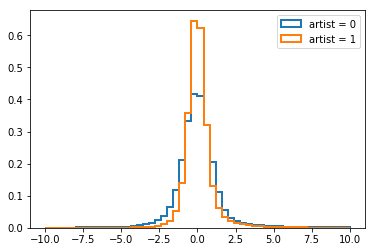

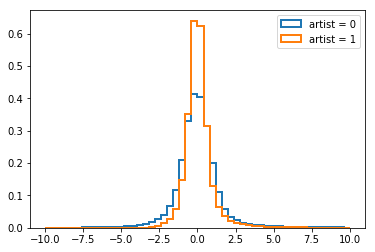

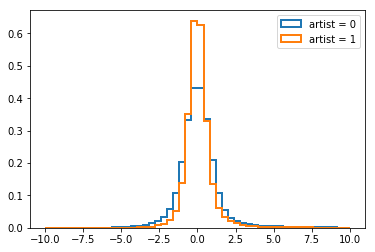

In [192]:
for X, y in zip([X_train, X_test, X_val], [y_train, y_test, keras.utils.to_categorical(y_val, n_classes)]):
    for p in [0,1]:
        plt.hist(get_flat_data(X, y, p), 50, density=True, 
             label = f'artist = {p}', histtype='step', lw=2, range=(-10,10))
    plt.legend()
    plt.show()
